In [15]:
import pickle
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt

from insect_rl.algorithms.evaluation import IAVIEvaluation
from insect_rl.simulation import Simulation
from insect_rl.mdp.utils import grid_math
from insect_rl.plot import plot_grids

from iql.algorithms.iavi import inverse_action_value_iteration
import iql.plot_experiments as plt_exp

In [16]:
if "snakemake" not in locals().keys():
    experiment="Wystrach2020"
    condition="trap"
    wind=0.0
    inputs = [f"../../../irl/{experiment}/{condition}/{wind}/envc.pickle", 
              f"../../../irl/{experiment}/{condition}/transition_probs_wind={wind}.npy",
              f"../../../irl/{experiment}/{condition}/{wind}/results/action_probs.npy",
              f"../../../irl/{experiment}/{condition}/{wind}/results/ground_r.npy",
              f"../../../irl/{experiment}/{condition}/{wind}/results/q.npy",
              f"../../../irl/{experiment}/{condition}/{wind}/results/r.npy",
              f"../../../irl/{experiment}/{condition}/{wind}/results/boltz.npy"
             ]
else:
    inputs = snakemake.input

In [37]:
with open(inputs[0], 'rb') as envc_file:
    envc = pickle.load(envc_file)


transition_probs = np.load(inputs[1])
action_probs = np.load(inputs[2])
ground_r = np.load(inputs[3])

q = np.load(inputs[4])
r = np.load(inputs[5])
boltz = np.load(inputs[6])

In [ ]:
envc.goals
def centroid(data):
    x, y = zip(*data)
    l = len(x)
    return int(round(sum(x) / l)), int(round(sum(y) / l))
centroid(envc.goals)


In [54]:
#exit:(17,30), (17,31), 18
# ((1, 0), (0, 1), (-1, 0), (0, -1), (-1,-1), (-1,1), (1,-1), (1,1))
p1 = grid_math.point_to_int((18,30), envc.width)
p2 = grid_math.point_to_int((19,30), envc.width)

In [55]:
transition_probs[p1][0][p2]

1.0

In [19]:
np.allclose(boltz, action_probs, rtol=1.e-5, atol=1.e-6)

True

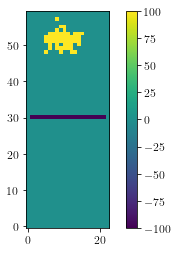

In [20]:
plt.imshow(ground_r.reshape(envc.height, envc.width))
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(snakemake.output[0])

In [21]:
%%capture
nS = envc.width * envc.height
nA = action_probs.shape[1]
v_iavi9 = plt_exp.policy_eval(boltz, ground_r, transition_probs, nS, nA, discount_factor=0.9, theta=0.001)
v_iavi99 = plt_exp.policy_eval(boltz, ground_r, transition_probs, nS, nA, discount_factor=0.99, theta=0.001)

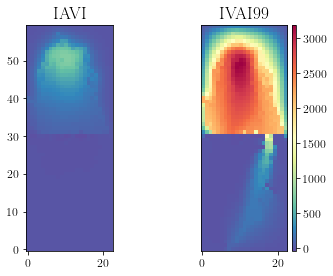

In [22]:
plot_grids(envc.width, envc.height, envc.start, IAVI90=v_iavi9, IVAI99=v_iavi99)
plt.savefig(snakemake.output[1])

In [23]:
V = np.zeros(nS)
for s in range(nS):
    for a in range(nA):
        V[s] += boltz[s][a] * q[s][a]
R = np.zeros(nS)
for s in range(nS):
    for a in range(nA):
        R[s] += boltz[s][a] * r[s][a]

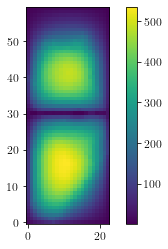

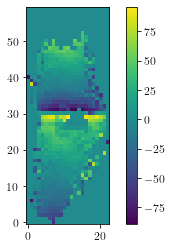

In [24]:
plt.imshow(V.reshape(envc.height, envc.width))
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(snakemake.output[2])

plt.imshow(R.reshape(envc.height, envc.width))
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(snakemake.output[3])


In [25]:
%%capture
v_iaviR = plt_exp.policy_eval(boltz, R, transition_probs, nS, nA, discount_factor=0.99, theta=0.001)

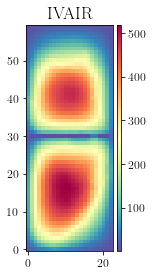

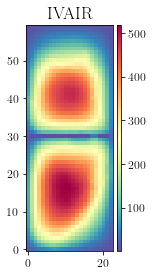

In [26]:
plot_grids(envc.width, envc.height, envc.start, IVAIR=v_iaviR)
plt.savefig(snakemake.output[4])

In [27]:
%%capture
#p_start_state = (np.bincount(trajectories[:, 0, 0], minlength=env.n_states)/trajectories.shape[0])



# V(s) <- sum[Au: T(s,a,u) * p(s,a) * (r(s) + discount * V(u)) ]

# results of boltzman policy inferred via iavi and the ground truth reward
#v_iavi = plt_exp.policy_eval(boltz, ground_r, transition_probs, nS, nA, discount_factor=0.99, theta=0.001)

# results of the action probabilities taken from the trajectories
v_true = plt_exp.policy_eval(action_probs, ground_r, transition_probs, nS, nA, discount_factor=0.99, theta=0.001)

# found via value iteration
b = plt_exp.find_policy(nS, nA, transition_probs, ground_r, discount=0.99, threshold=1e-2)
v_valueit = plt_exp.policy_eval(b, ground_r, transition_probs, nS, nA, discount_factor=0.99, theta=0.001)


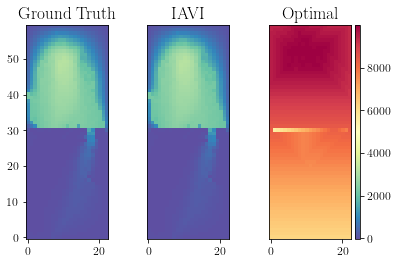

In [28]:
fig = plot_grids(envc.width, envc.height, envc.start, Ground_Truth=v_true, IAVI=v_iavi99, Optimal=v_valueit)
#w = snakemake.wildcards
#label = "condition: " + w['condition'] + ", wind: " + w['wind'] + ", reward: " + "100" + ", trap cost: " + "-100"
plt.subplots_adjust(top=0.85)
#fig.suptitle(label, fontsize=16)
plt.savefig(snakemake.output[5])